# How to get these notebooks to work

Dataset describe here: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

git clone git@github.com:franzoni/proton-Hands-on_task_Senior_Data_Scientist.git

mv online_retail_II.xlsx proton-Hands-on_task_Senior_Data_Scientist

In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

data_path = os.getcwd()
print('++ Directory of this notebook:')
print('\t%s'%data_path)

excel_with_path  = data_path+'/online_retail_II.xlsx'
pickle_with_path = data_path+'/online_retail_II.pkl'
csv_with_path    = data_path+'/online_retail_II.csv'

print('\n++Full path of the data file:')
print('\tdata_path =%s\n\n'%excel_with_path)

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)
    print('-> picke done\n')

++ Directory of this notebook:
	/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist

++Full path of the data file:
	data_path =/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist/online_retail_II.xlsx


-> picke already exists, much faster using it than opening excel files



In [2]:
# what are the nulls in each feature?
nulls = df.isnull().sum()[df.isnull().sum() != 0]

# select all transactions containing 
df_nulls = df[df.isnull().any(axis=1)].copy(deep=True)

nulls_rel = nulls/df.shape[0]*100

nulls_summary = pd.concat([nulls, nulls_rel], axis=1, keys=['nulls', 'rel. nulls [%]'])\
               .sort_values('nulls', ascending=False)

nulls_summary

,nulls,rel. nulls [%]
Customer ID,243007,22.766873
Description,4382,0.410541


<a id="section_EDA_engineering"></a>

# define transaction: total cash for a single 'row' of the dataset, i.e. item_price times the number of items bought
- and other dataset engineering

In [3]:
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# day, week and time are added for convenience of analysis later on
from datetime import datetime
df['InvoiceDay'] = df['InvoiceDate'].map(lambda p: p.date())
df['InvoiceWeekDay'] = df['InvoiceDate'].map(lambda p: p.weekday())
df['InvoiceTime'] = df['InvoiceDate'].map(lambda p: p.time())
df['InvoiceWeek'] = df['InvoiceDate'].map(lambda p: p.isocalendar()[1]+52*(p.year-2010))

# avoide negative weeks and start counting from the first week of the dataset, which starts from 01/12/2009
df['InvoiceWeek'] = df['InvoiceWeek']+3

In [4]:
df.describe()

,Quantity,Price,Customer_ID,Transaction,InvoiceWeekDay,InvoiceWeek
count,1.067371e+06,1.067371e+06,824364.000000,1.067371e+06,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00,15324.638504,1.806987e+01,2.462998e+00,5.559349e+01
std,1.727058e+02,1.235531e+02,1697.464450,2.924202e+02,1.880427e+00,3.118122e+01
min,-8.099500e+04,-5.359436e+04,12346.000000,-1.684696e+05,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.250000e+00,13975.000000,3.750000e+00,1.000000e+00,3.000000e+01
50%,3.000000e+00,2.100000e+00,15255.000000,9.900000e+00,2.000000e+00,5.200000e+01
75%,1.000000e+01,4.150000e+00,16797.000000,1.770000e+01,4.000000e+00,8.400000e+01
max,8.099500e+04,3.897000e+04,18287.000000,1.684696e+05,6.000000e+00,1.040000e+02


# Implement the definition of cancellation in the documentation:

http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
      ==> "If this code starts with the letter 'c', it indicates a cancellation.""

In [5]:
def is_cancellation(s):
    if isinstance(s, int):
        return 0
    elif isinstance(s, unicode):
        if s.rfind('C')!=-1:
            return 1
        else:
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)

In [6]:
df['IsCancellation'].value_counts()

0    1047871
1      19494
2          6
Name: IsCancellation, dtype: int64

Items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
There'a lot of transactions with price set to 0, which based on the descriptions are spurious

In [7]:
len((df.loc[ (df.Price ==0.)]))

6202

In [8]:
#(df.loc[ (df.Price ==0.)]).head(100)

In [9]:
max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item)        

In [10]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,1,07:45:00,0,0,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,1,07:45:00,0,0,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,1,07:45:00,0,0,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,1,07:45:00,0,0,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,1,07:45:00,0,0,1


NEARLY all cancellations have either Quantity or Price set to negative values
there are only two exceptions, here below:
           one of which is an actual cancellation
           the second of which is an onforeseen transaction type which starts with A

In [11]:
(df.loc[ (df.IsCancellation > 0.) & (df.Transaction > 0.) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,373.57,2010-02-01,0,08:24:00,8,1,1
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,4,14:50:00,87,2,0


In [12]:
# there are 6 data entries which are neither normal transactions nor cancellations which are neither 
# they're described as "Adjust bad debt"
(df.loc[ (df.IsCancellation == 2) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,-53594.36,2010-04-29,3,13:36:00,20,2,0
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,-44031.79,2010-07-19,0,11:24:00,32,2,0
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,-38925.87,2010-10-20,2,12:04:00,45,2,0
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,4,14:50:00,87,2,0
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,4,14:51:00,87,2,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,4,14:52:00,87,2,0


In [13]:
# remove the "Adjust bad debt"
(df.loc[ (df.IsCancellation == 2) ])


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,-53594.36,2010-04-29,3,13:36:00,20,2,0
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,-44031.79,2010-07-19,0,11:24:00,32,2,0
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,-38925.87,2010-10-20,2,12:04:00,45,2,0
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,4,14:50:00,87,2,0
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,4,14:51:00,87,2,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,4,14:52:00,87,2,0


## todo
- nan and empty -> cleanup   # IN THE MAKING -> only consequences on the users study
- add colums for data and time, separately ?    # DONE
- create a second DF by user: RFM added to


## What do I want to extract from this dataset?
- https://en.wikipedia.org/wiki/Exploratory_data_analysis

- how many customers   DONE, also as a function of country
- make a pliot of transaction, of purchase prices, and of invoice_price! #  DONE

- VS TIME: trends of spending overall, by country
- revenue as a function of date, as a function of the time in the day  # DONE
- trends of spending: overall, by the largest customer, by the smaller customers (TOO SPECIFIC?)

- NEED TO BUILD A PER CUSTOMER DF
- customer: how many transactions, how much total revenue:
    => BREAK DOWN BY country, tra
- RMF


- ==> do this
- how many different types of items                  # DONE
- what kind of items are bought the most (by NUMBER of by REVENUE), are cancelled the most, 
- how much revenue per type of item bought

- correlation between
- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?

- cust.groupby('customer_unique_id').size().value_counts() => The majority of customers made only a single purchase. # DONE


- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/
- now many items are bought per session, how much is spent per session

==> TOWARDS CUSTOMER PERSONA DEFINITION
- MANY TRANSACTIONS ARE RECORDED AT THE SAME TIME => as if they were a single shopping session, but billed in split goups of goods
- the function summary_data_from_transaction_data treats transactions taking place on the same day as A SINGLE ONE!

- What are the most popular products that are bought in the UK?


---
<a id="section_ID_GF"></a>

- this section can be reached at this URL https://swan001.cern.ch/user/franzoni/notebooks/SWAN_projects/proton/proton-EDA.ipynb#section_ID_GF
- thanks to this documentation

<a id="section_EDA_single_items"></a>
## SINGLE ITEM PRICE AND single item purchases
- how many single items are there (ordinary transaction) # DONE
- what is the cost of each single item
- what is the purchase frequency of each item

- what is the resulting price distribution for all transactions

In [14]:
# I consider here only transactions with positive proceeds

transaction_plus   = (df.loc[df.Transaction > 0.]).Transaction.agg([sum])
transaction_cancel = (df.loc[df.Transaction < 0.]).Transaction.agg([sum])
print('The total cash intake is %e pounds,\n the total amount from cancellations is %e (%f )' \
        %(transaction_plus,transaction_cancel,-100*transaction_cancel/transaction_plus))

The total cash intake is 2.097297e+07 pounds,
 the total amount from cancellations is -1.685718e+06 (8.037573 )


In [15]:
print('there are %d unique ordinary items'%len(df.loc[(df['IsOrdinaryItem']==1)].Description.unique()))

there are 5414 unique ordinary items


In [16]:
print('%d purchass are below 10 punds'%len(df.loc[(df['IsOrdinaryItem']==1) & (df['Price']<10)] ))

1009425 purchass are below 10 punds


Text(0,0.5,' ')

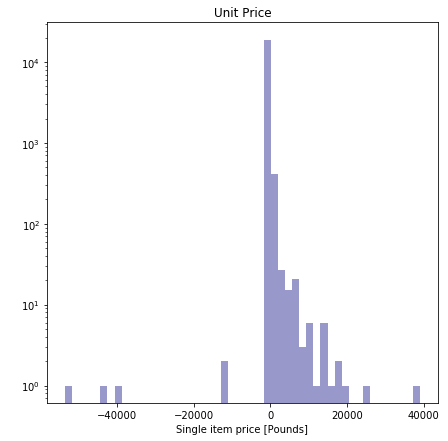

In [17]:
# Exclude cancellations to get the spectrum of single items price
# motivation: the cancellation would give rise to a double counting

# NOTE: cancellations are sometimes negative Quantity for positive price,
# other times they are positive Quantity and negative price
tit='Unit Price'
#(df.loc[ (df.Price > 0.) & (df.Quantity > 0)]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))

(df.loc[ (df.IsCancellation >0 ) ]) \
 .Price.plot(kind='hist',logy=True,title=tit,bins=50, \
     colormap='terrain',alpha=0.5,figsize=(7,7))

plt.xlabel('Single item price [Pounds]')
plt.ylabel(' ')

count    1.041589e+06
mean     3.758929e+00
std      1.426855e+01
min      1.000000e-03
25%      1.250000e+00
50%      2.100000e+00
75%      4.130000e+00
max      1.343440e+03
Name: Price, dtype: float64

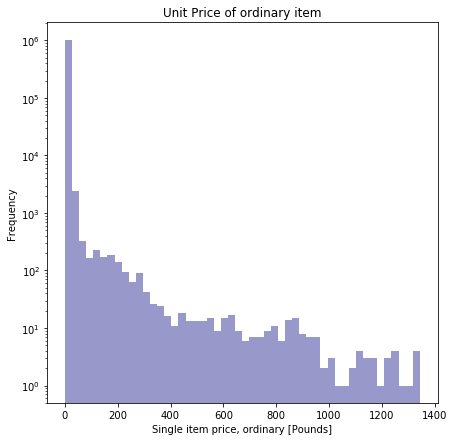

In [18]:
tit='Unit Price of ordinary item'

(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1)]) \
     .Price.plot(kind='hist',logy=True,title=tit,bins=50 \
     ,colormap='terrain',alpha=0.5,figsize=(7,7))

plt.xlabel('Single item price, ordinary [Pounds]')

(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1)]) \
     .Price.describe()

In [19]:
fraction_non_ordinary=100.*len(df.loc[  (df['IsOrdinaryItem']!=1)]) / len( (df.loc[  (df['IsOrdinaryItem']==1)])   )
print('%f percent of the total items are non ordinary, defined as above %d or zero'%(fraction_non_ordinary,max_item_price))

0.602368 percent of the total items are non ordinary, defined as above 1400 or zero


In [20]:
#df.loc[ (df['IsOrdinaryItem']==1) ].groupBy('Description').unique()

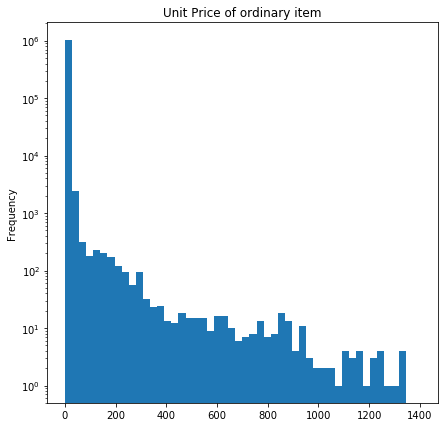

In [21]:
(df.loc[ (df.IsCancellation ==0 ) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

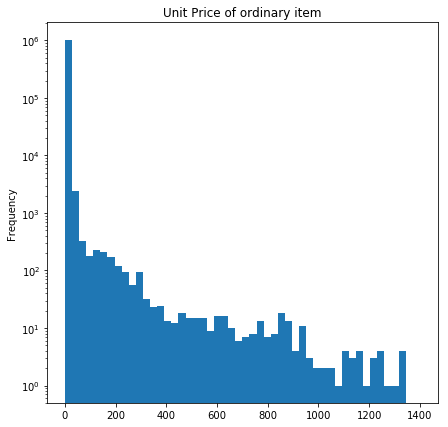

In [22]:
(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

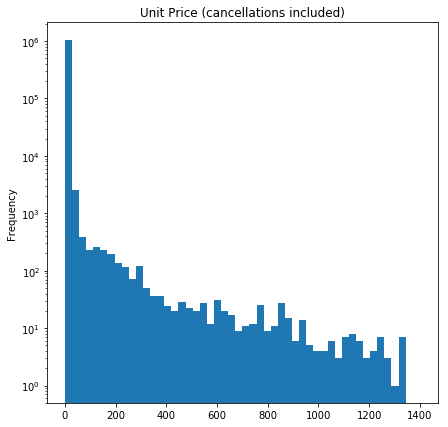

In [23]:
# alternative logic: account for cancelled items, as if they were normal purchases
tit='Unit Price (cancellations included)'
df['Price'].map(lambda p: abs(p)) \
           .plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

<a id="section_EDA_ordinary_items"></a>
# DEFINE ordinary items

In [24]:
# What are the transactions-or-cancellations above max_item_price
# see them all
# df.loc[ (df.Price > max_item_price) | (df.Price < -1*max_item_price) ].head(20000)

# group them by Description to see what they are and how many 
df.loc[ (df.IsOrdinaryItem==0) & (df.Price>0) ].groupby('Description').Description.agg([len]) \
              .rename(columns={"len": "item_huge_price"})            \
              .sort_values(by=['item_huge_price'],ascending=False)


# All prices/cancellatons in excess of 1500 are 'special accounting actions',
# and are not actual goods being purchased

,item_huge_price
Description,
Manual,123
AMAZON FEE,39
DOTCOM POSTAGE,16
POSTAGE,2
Adjust bad debt,1
Adjustment by john on 26/01/2010 17,1
Bank Charges,1
Discount,1


In [25]:
# how many ORDINARY items are on the cathalogue, based on unique description and price not set to 0
len(df.loc[ df.IsOrdinaryItem==1 ].Description.unique())

5414

In [26]:
# transactions with 0 prices --> all have odd/dodgy descriptions: manipulation errors and the like
df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)]
len(df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)])
# this is 0 by construction, since IsOrdinaryItem flips to 0 of Price==0

0

<a id="section_EDA_items"></a>
# carachterising items and their prices

In [ ]:
print('Several ordinary items are sold at different prieces; what fraction have different prices and what fraction has identical price?')

def is_price_unique(row):
    if row.min>=row.max and row.min<=row.max:
        row.price_unique=100 
        print('')

        print(row.min)
        print(row.max)
        print(row)
        print('--> the same')
    else:
        row.price_unique=999
        print('')
        print('')
        print(row.min)
        print(row.max)
        print(row)
        print('--> NOT the same')
    return row
# https://stackoverflow.com/questions/27474921/compare-two-columns-using-pandas

#a = df.loc[ df.IsOrdinaryItem==1 ].groupby('Description').Price.agg([len,min,max,sum]) \
#                                  .sort_values(by=['sum'],ascending=False)             \

#b=a.apply(is_price_unique, axis='columns')
#b

# IN THE MAKING
# TO DO: make a spectrum of the price for each element in the cathalogue

# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
import numpy as np
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
    
df_items = df.loc[ df.IsOrdinaryItem==1 ].groupby('Description')        \
                         .Price.agg([len,min,           \
                                    percentile(10),    \
                                    percentile(25),    \
                                    percentile(50),    \
                                    percentile(75),    \
                                    percentile(90),    \
                                    max,sum])          \
                                    .rename(columns={"sum": "item_revenue","len":"item_num"})  

# this is an indication of the spread of the price of a given item
df_items['percentile_ratio_7525'] = df_items['percentile_75'] / df_items['percentile_25'] 
df_items['percentile_ratio_9010'] = df_items['percentile_90'] / df_items['percentile_10'] 

df_items.loc[ df_items['item_revenue']>10000  ].sort_values(by=['item_revenue'],ascending=False)

count      5414.000000
mean        771.130969
std        5231.959139
min           0.040000
25%          51.435000
50%         190.580000
75%         611.627500
max      291471.720000
Name: item_revenue, dtype: float64

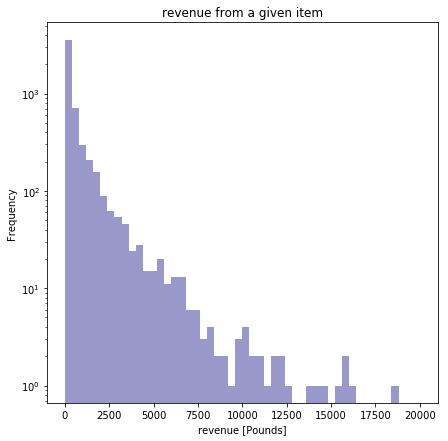

In [28]:
# how much money has been made with each given item
# excluding the top three values which are not purchasable items
tit='revenue from a given item'
r  = (0,20000)
df_items['item_revenue'].plot(kind='hist',logy=True,title=tit,bins=50 \
     ,colormap='terrain',alpha=0.5,range=r,figsize=(7,7))
plt.xlabel('revenue [Pounds]')
df_items['item_revenue'].describe()

count    5414.000000
mean      195.969708
std       319.905730
min         1.000000
25%        21.000000
50%        81.000000
75%       233.000000
max      5913.000000
Name: item_num, dtype: float64

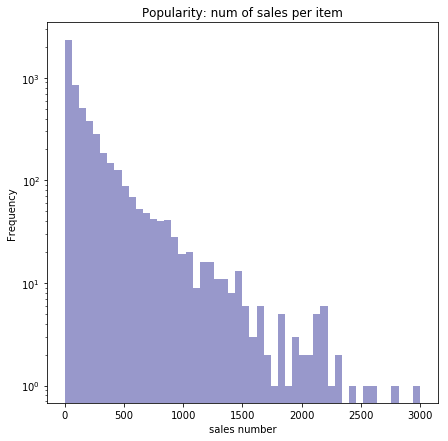

In [29]:
# how many times has each item been sold ?
tit='Popularity: num of sales per item'
r  = (0,3000)
df_items['item_num'].plot(kind='hist',logy=True,title=tit,bins=50, \
                          colormap='terrain',alpha=0.5,range=r,figsize=(7,7))
plt.xlabel('sales number')
df_items['item_num'].describe()

In [30]:
df_items.loc[ (df_items.item_num>3000)]

,item_num,min,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,max,item_revenue,percentile_ratio_7525,percentile_ratio_9010
Description,,,,,,,,,,,
JUMBO BAG RED RETROSPOT,3465.0,1.65,1.79,1.95,2.08,2.08,4.13,5.06,8230.47,1.066667,2.307263
REGENCY CAKESTAND 3 TIER,4408.0,4.00,10.95,12.75,12.75,12.75,24.96,32.04,61747.01,1.000000,2.279452
WHITE HANGING HEART T-LIGHT HOLDER,5913.0,1.90,2.55,2.95,2.95,2.95,2.95,6.77,18488.35,1.000000,1.156863


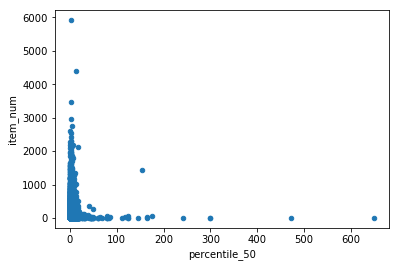

In [31]:
# correlation between number of times an item has been sold and its single price ?
df_items.plot.scatter(x='percentile_50',
                      y='item_num',
                      #c='species',
                      #colormap='viridis'
                     )

In [32]:
df_items['percentile_50'].values

array([ 6.75,  1.95,  2.55, ...,  0.85, 10.4 ,  3.75])

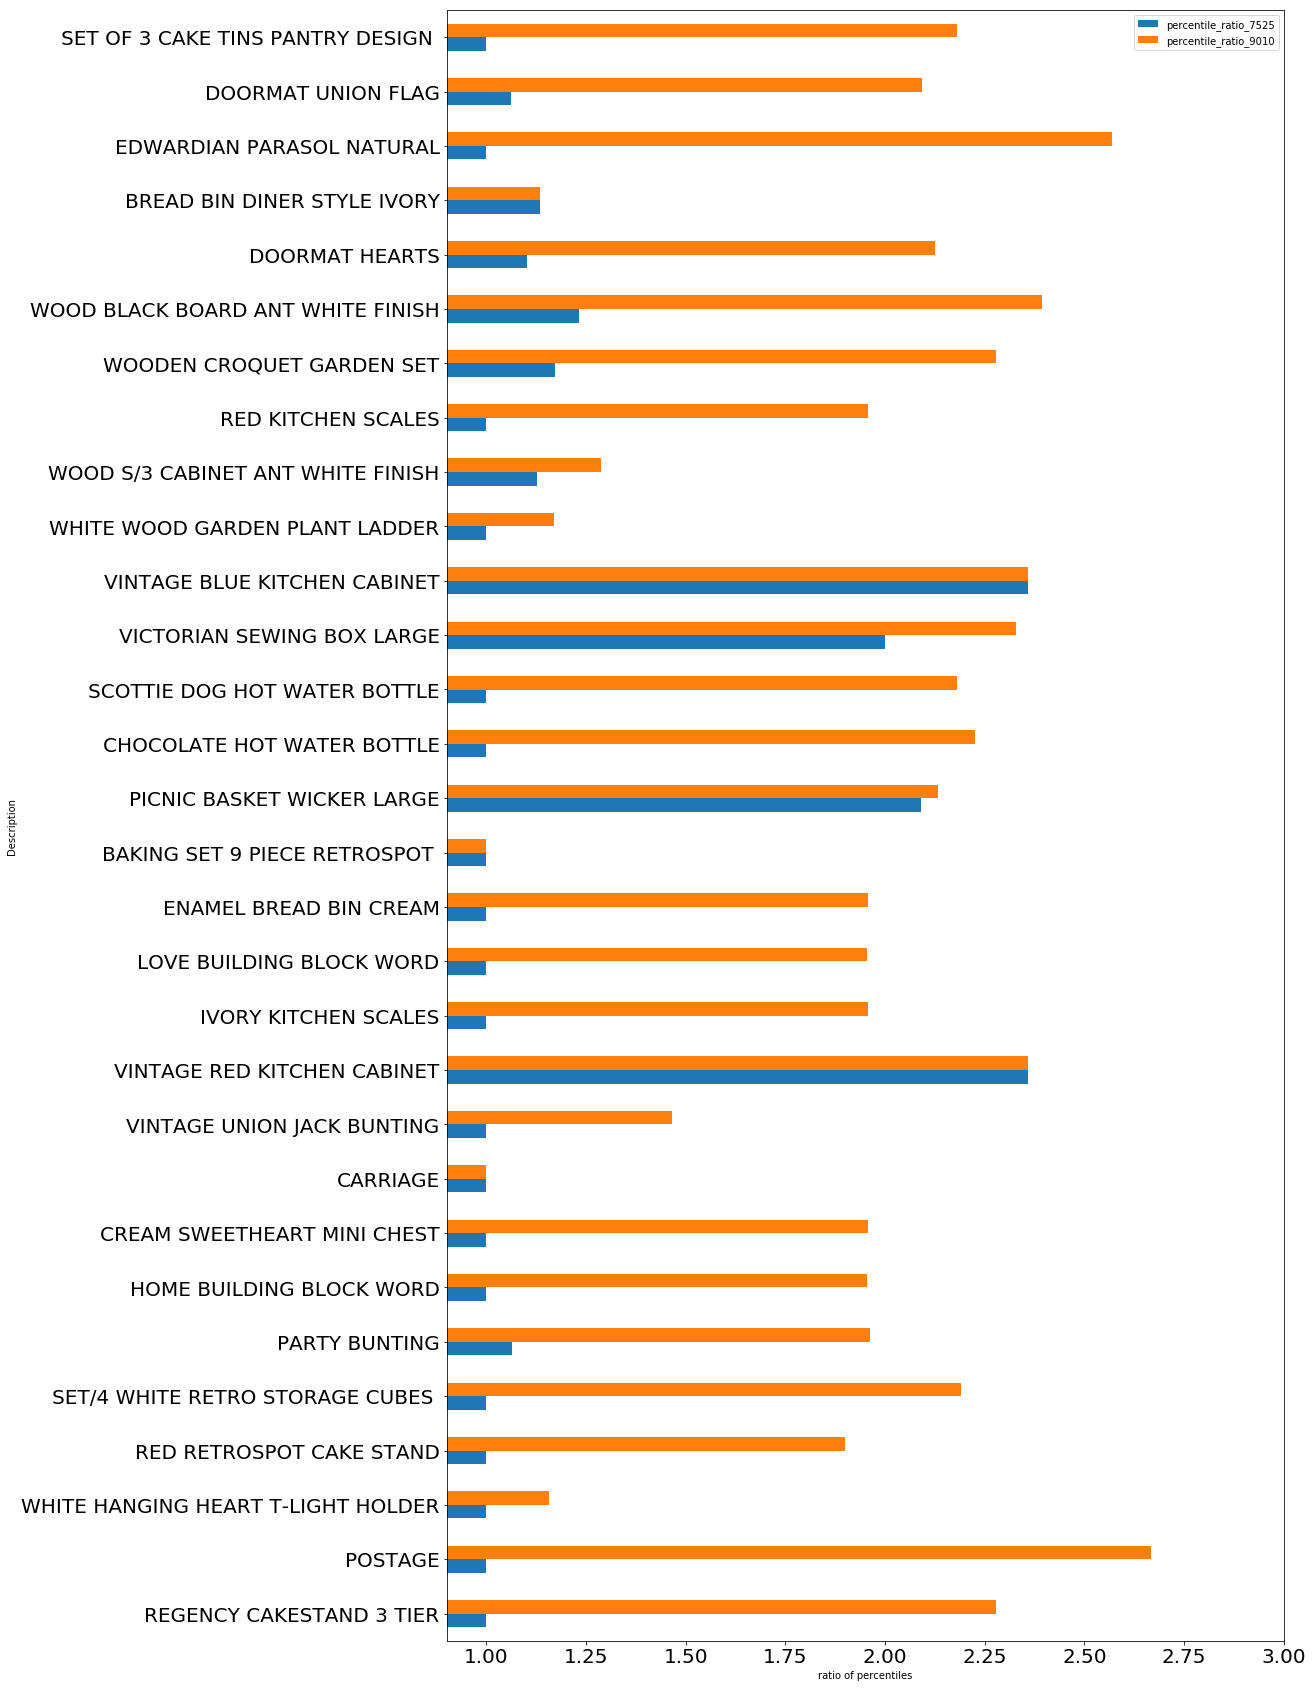

In [33]:
# relative difference between the 75 and the 25 percentile prices
# as function if item type, ordered by descending per-item total revenue
# the first three items are not actual purchable items
# 
df_items.loc[ (df_items['item_revenue']>8500) & (df_items['percentile_ratio_7525']<3) ]                        \
        .sort_values(by=['item_revenue'],ascending=False)[['percentile_ratio_7525','percentile_ratio_9010']]          \
        .plot.barh(rot=0,figsize=(15,30),logy=False,fontsize=20,xlim=(0.9,3.),subplots=False)
plt.xlabel('ratio of percentiles')

plt.rc('legend',fontsize=20)

<a id="section_EDA_transactions"></a>
## Transaction carachteristics

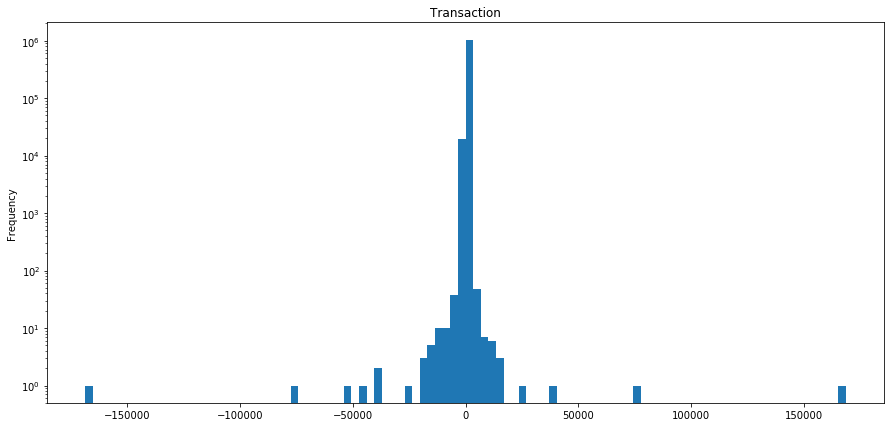

In [34]:
tit='Transaction'
df['Transaction'].plot(kind='hist',logy=True,title=tit,bins=100,figsize=(15,7))

# Distribution of the amounts per recorded TRANSACTION
- Take away message: at high costs, the cancellations have larger relative importance

count    1.041671e+06
mean     2.013397e+01
std      2.031167e+02
min      1.000000e-03
25%      3.900000e+00
50%      9.960000e+00
75%      1.770000e+01
max      1.684696e+05
Name: Transaction, dtype: float64

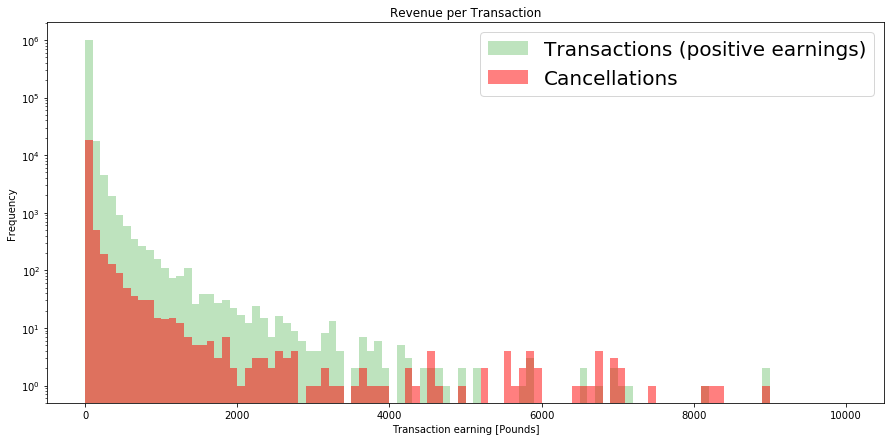

In [35]:
from matplotlib.pyplot import *

tit='Revenue per Transaction'
fig, ax = subplots()

df.loc[ (df.Transaction >0) ].Transaction              \
       .plot(kind='hist',logy=True,title=tit,bins=100,  \
             range=(0,10000),figsize=(15,7),colormap='Accent',alpha=0.5,legend=True)

df.loc[ (df.Transaction <0) ].Transaction.map(lambda u: -1*u)              \
       .plot(kind='hist',logy=True,title=tit,bins=100,  \
             range=(0,10000),figsize=(15,7),colormap='autumn',alpha=0.5,legend=True)

ax.legend(['Transactions (positive earnings)', 'Cancellations'])
plt.xlabel('Transaction earning [Pounds]')

df.loc[ (df.Transaction >0) ].Transaction.describe()

In [36]:
df.loc[ (df.Transaction <0) ].Transaction.map(lambda u: -1*u).describe()

count     19498.000000
mean         86.455922
std        1570.280818
min           0.120000
25%           3.750000
50%           8.950000
75%          17.850000
max      168469.600000
Name: Transaction, dtype: float64

<a id="section_invoicess"></a>
## Invoices carachteristics
-- can be browsed to directly from here https://nbviewer.jupyter.org/github/franzoni/proton-Hands-on_task_Senior_Data_Scientist/blob/master/proton-EDA.ipynb#section_invoicess

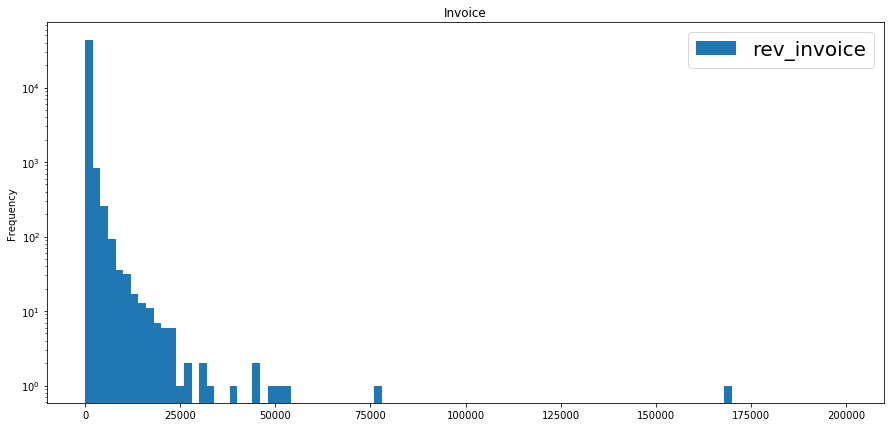

In [37]:
tit='Invoice'
df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \
   .sort_values(by=['rev_invoice'],ascending=False)  \
   .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,200000),figsize=(15,7))

<a id="section_EDA_invoices"></a>

# Distribution of the amounts per recorded INVOICE

count     40078.000000
mean        523.303761
std        1517.351646
min           0.190000
25%         151.972500
50%         304.315000
75%         504.892500
max      168469.600000
Name: rev_invoice, dtype: float64

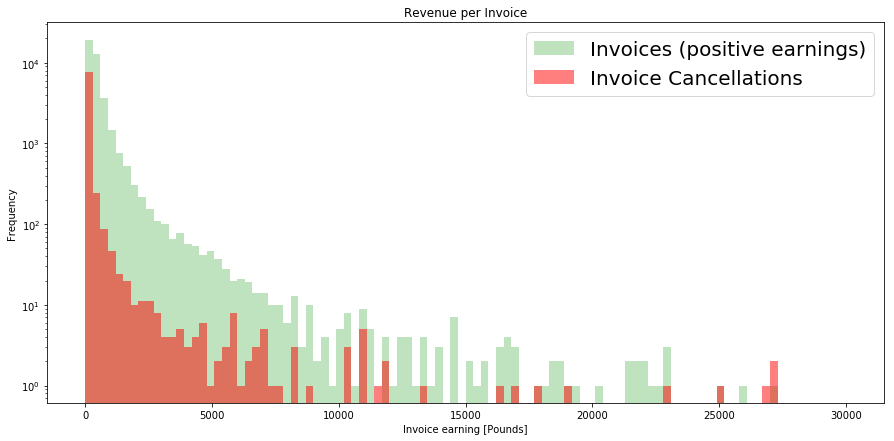

In [38]:
tit='Revenue per Invoice'

fig, ax = subplots()

df_invoices= df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \

df_invoices.loc[ (df_invoices.rev_invoice >0) ]                      \
        .sort_values(by=['rev_invoice'],ascending=False).rev_invoice  \
        .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,30000),figsize=(15,7),colormap='Accent',alpha=0.5,legend=True)

df_invoices.loc[ (df_invoices.rev_invoice <0) ]         \
        .sort_values(by=['rev_invoice'],ascending=False).rev_invoice.map(lambda u: -1*u)   \
        .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,30000),figsize=(15,7),colormap='autumn',alpha=0.5,legend=True)

plt.xlabel('Invoice earning [Pounds]') 
ax.legend(['Invoices (positive earnings)', 'Invoice Cancellations'])

df_invoices.loc[ (df_invoices.rev_invoice >0) ]                      \
        .sort_values(by=['rev_invoice'],ascending=False).rev_invoice.describe()

In [39]:
df_invoices.loc[ (df_invoices.rev_invoice <0) ]         \
        .sort_values(by=['rev_invoice'],ascending=False).rev_invoice.map(lambda u: -1*u).describe()

count      8296.000000
mean        203.196428
std        2460.115707
min           0.390000
25%           8.450000
50%          17.400000
75%          43.577500
max      168469.600000
Name: rev_invoice, dtype: float64

<a id="section_EDA_countries"></a>
## Countries carachteristics

In [40]:
print('There are %d unique customers'%len(df.Customer_ID.unique()))

There are 5943 unique customers


In [41]:
print('Customers are from %d countries'%len(df.Country.unique()))

Customers are from 43 countries


In [42]:
# toggle between the whole dataset (df) and the transactions w/ Customer_ID=Nan 
# to check for biases
UU = df

Cust_vs_country = UU.groupby('Country').Customer_ID.unique().agg([len])     \
                    .rename(columns={"len": "num_customers"})               \
                    .sort_values(by=['num_customers'],ascending=False)

# I consider here only transactions with positive proceeds
# I'll make a dedicated plot/column here below for negative/cancelled goods
Revenue_vs_country = (UU.loc[UU.Transaction > 0.])                        \
                     .groupby('Country').Transaction.agg([sum])           \
                    .rename(columns={"sum": "revenue"})                     \
                    .sort_values(by=['revenue'],ascending=False)

Cancellation_vs_country = (UU.loc[UU.Transaction < 0.])                \
                          .groupby('Country').Transaction.agg([sum])    \
                          .rename(columns={"sum": "cancellation"})            \
                          .sort_values(by=['cancellation'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Items_vs_country = UU.groupby('Country').Invoice.agg([len])    \
                    .rename(columns={"len": "num_items"})            \
                    .sort_values(by=['num_items'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Invoices_vs_country = UU.groupby('Country').Invoice.unique().agg([len])    \
                    .rename(columns={"len": "num_invoices"})            \
                    .sort_values(by=['num_invoices'],ascending=False)

NoCustomerID_vs_country = df[df.isnull().any(axis=1)]                \
                    .groupby('Country').Transaction.agg([sum])     \
                    .rename(columns={"sum": "no_customer_id"})            \
                    .sort_values(by=['no_customer_id'],ascending=False) \

df_vs_country = Cust_vs_country              \
                .join(Revenue_vs_country )    \
                .join(Cancellation_vs_country)    \
                .join(Items_vs_country)   \
                .join(Invoices_vs_country)   \
                .join(NoCustomerID_vs_country,how='outer')   \
                .fillna(0)                                  \
                .sort_values(by=['revenue'],ascending=False) \

df_vs_country['rel_cancellation']   = \
           -100*df_vs_country['cancellation']/df_vs_country['revenue']

df_vs_country['rel_no_customer_id'] = \
            100*df_vs_country['no_customer_id']/df_vs_country['revenue']

In [43]:
NoCustomerID_vs_country

,no_customer_id
Country,
United Kingdom,2.576161e+06
EIRE,3.701792e+04
Hong Kong,1.403930e+04
Unspecified,2.310560e+03
France,1.687130e+03
Bahrain,1.507180e+03
RSA,1.435290e+03
Bermuda,1.253140e+03
Israel,9.135700e+02


In [44]:
df_vs_country['rel_cancellation']

Country
United Kingdom            8.330469
EIRE                      7.361513
Netherlands               1.029783
Germany                   3.077917
France                    8.055256
Australia                 1.670337
Spain                    15.863055
Switzerland               1.269690
Sweden                    4.454988
Denmark                   5.898899
Belgium                   3.313790
Norway                   34.714227
Portugal                  8.411120
Japan                     7.131788
Channel Islands           7.874234
Italy                     5.748221
Finland                   1.373710
Singapore                48.026509
Cyprus                    3.272161
Hong Kong                41.244195
Austria                   1.843941
Greece                    0.527330
Israel                    2.006589
United Arab Emirates     10.353382
Unspecified              11.418150
Poland                    3.433724
USA                      24.863808
Malta                    35.891316
Lithuania   

In [45]:
len(df_vs_country)

43

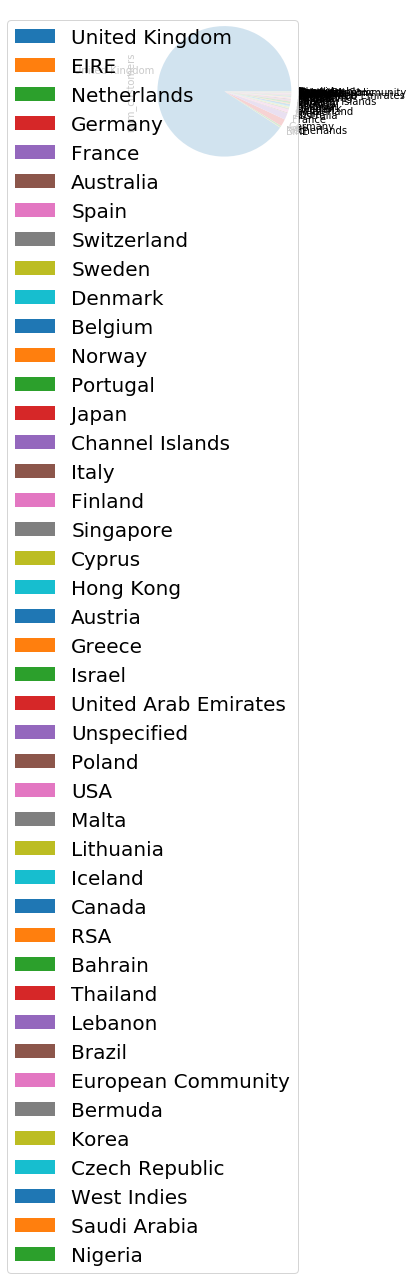

In [46]:
# https://www.w3resource.com/pandas/dataframe/dataframe-plot-bar.php
# good reference for plotting directly from pandas (less code!)
df_vs_country.plot.pie(y='num_customers', figsize=(3, 3))

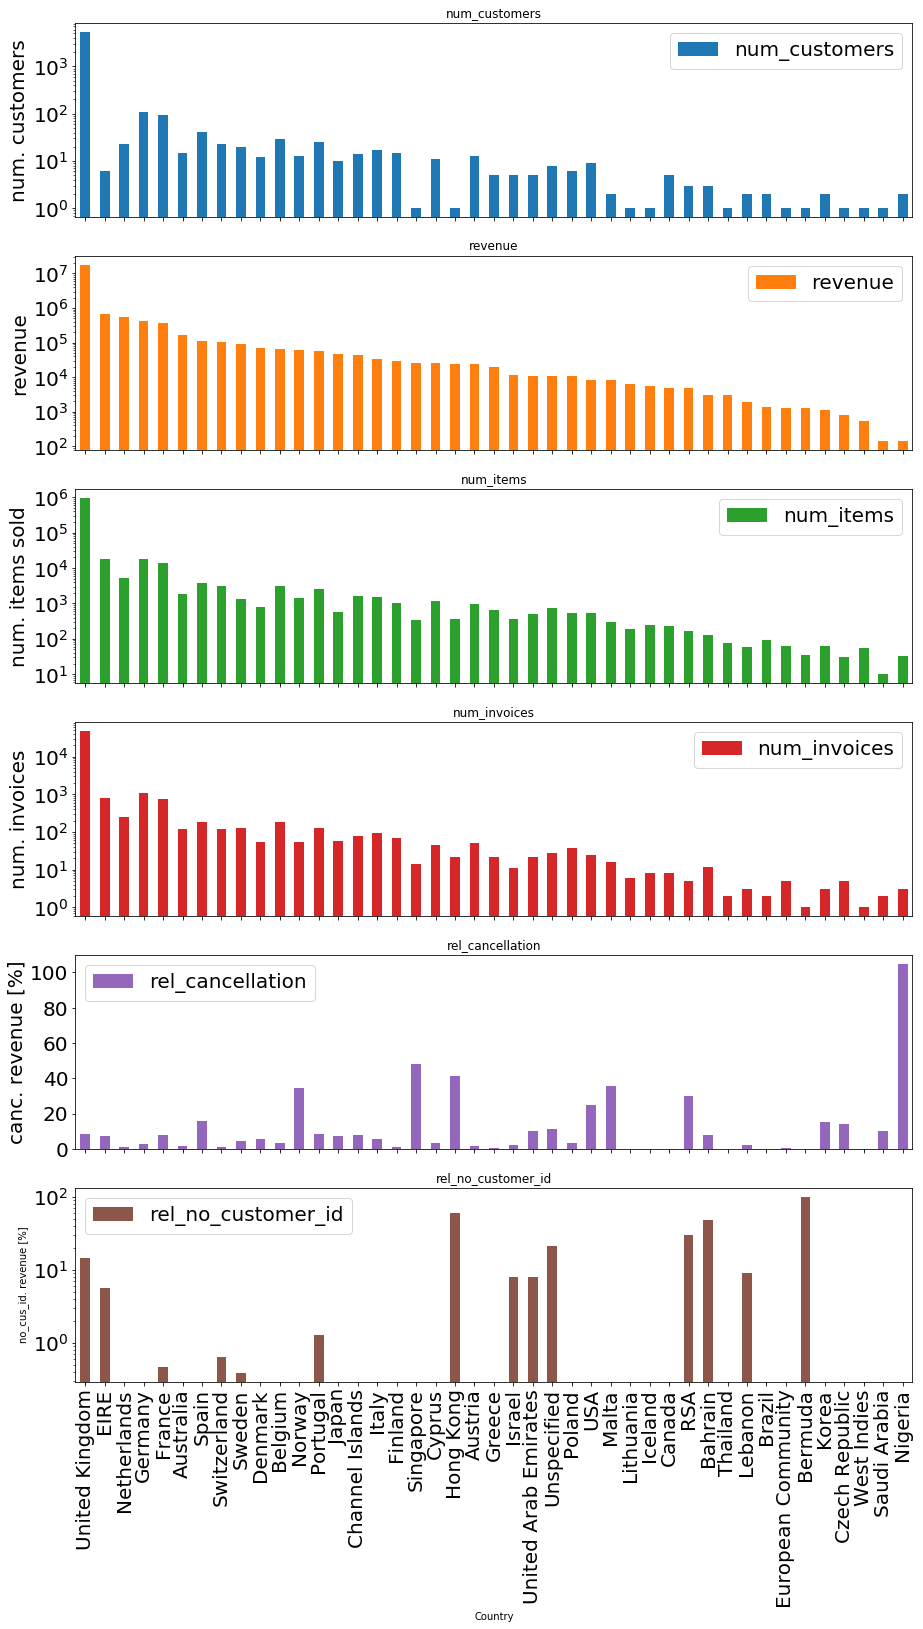

In [47]:
ax= df_vs_country.drop(['cancellation','no_customer_id'], axis=1)  \
    .plot.bar(rot=90,figsize=(15,25),logy=True,fontsize=20,subplots=True)

ax[0].set(ylabel = 'num. customers')
ax[1].set(ylabel = 'revenue')
ax[2].set(ylabel = 'num. items sold')
ax[3].set(ylabel = 'num. invoices')
ax[4].set(ylabel = 'canc. revenue [%]')
ax[4].set_yscale('linear')
ax[5].set(ylabel = 'no_cus_id. revenue [%]')
#ax[5].set_yscale('linear')

for v in range(5):
    ax[v].yaxis.get_label().set_fontsize(20)

<a id="section_EDA_datetime"></a>
## Date/Time carachteristics

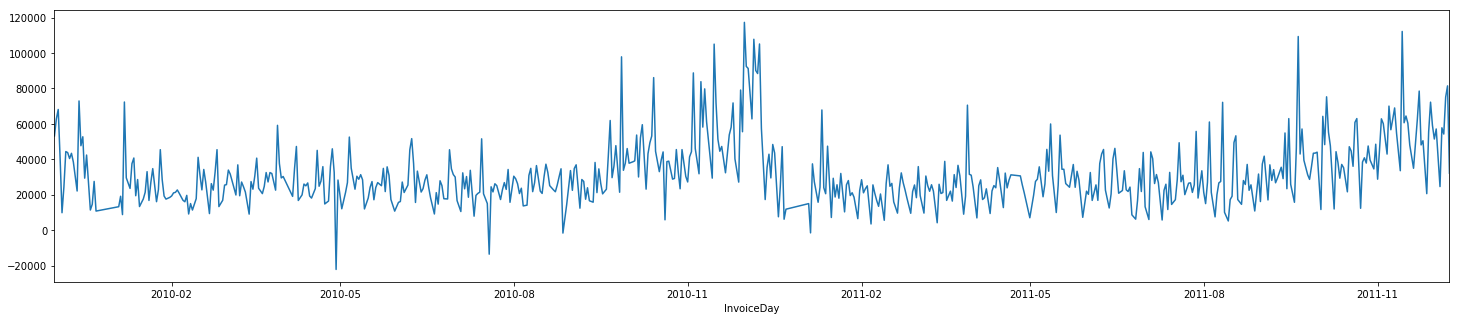

In [48]:
df.groupby('InvoiceDay').Transaction.agg(sum).plot(figsize=(25, 5))

Text(0,0.5,'Revenue per week [Pounds]')

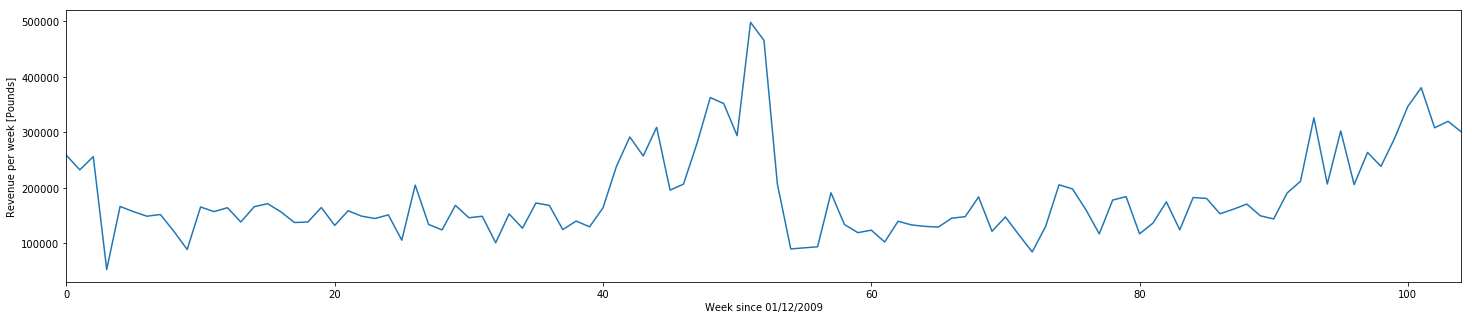

In [49]:
df.groupby('InvoiceWeek').Transaction.agg(sum).plot(figsize=(25, 5))
plt.xlabel('Week since 01/12/2009')
plt.ylabel('Revenue per week [Pounds]')

In [50]:
df.groupby('InvoiceWeek').Transaction.agg(sum).describe()

count       104.000000
mean     185454.332385
std       79726.269741
min       52800.490000
25%      133965.887500
50%      160993.420000
75%      206632.292750
max      498289.550000
Name: Transaction, dtype: float64

# Thursday is the day with the largest revenue, Saturday is the least, with near zero!


Thursday is the day with the largest revenue, Saturday is the least, with near zero!


Text(0,0.5,'Revenue per day [Pounds]')

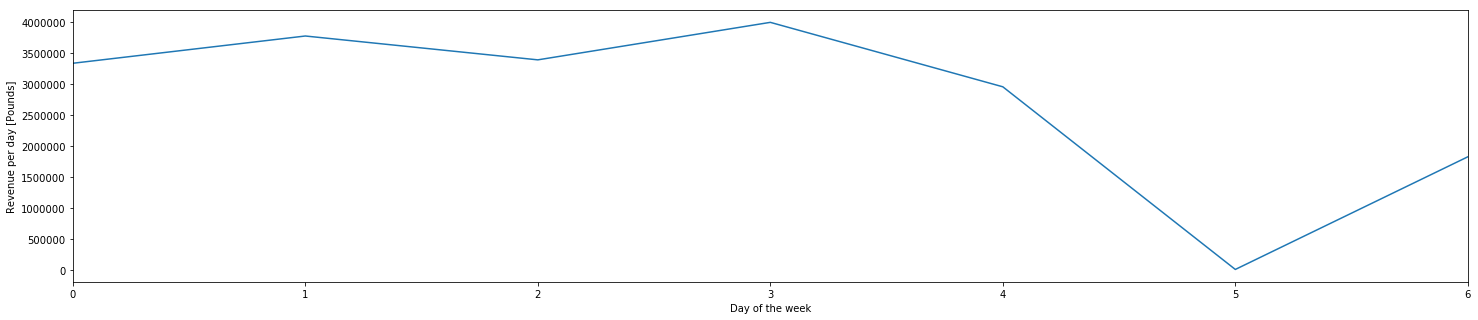

In [51]:
df.groupby('InvoiceWeekDay').Transaction.agg(sum).plot(figsize=(25, 5))
print('Thursday is the day with the largest revenue, Saturday is the least, with near zero!')
plt.xlabel('Day of the week')
plt.ylabel('Revenue per day [Pounds]')

In [52]:
df.groupby('InvoiceWeekDay').Transaction.agg(sum)

InvoiceWeekDay
0    3.335216e+06
1    3.774874e+06
2    3.390238e+06
3    3.995032e+06
4    2.955601e+06
5    9.803050e+03
6    1.826487e+06
Name: Transaction, dtype: float64

Text(0,0.5,'Revenue [Pounds]')

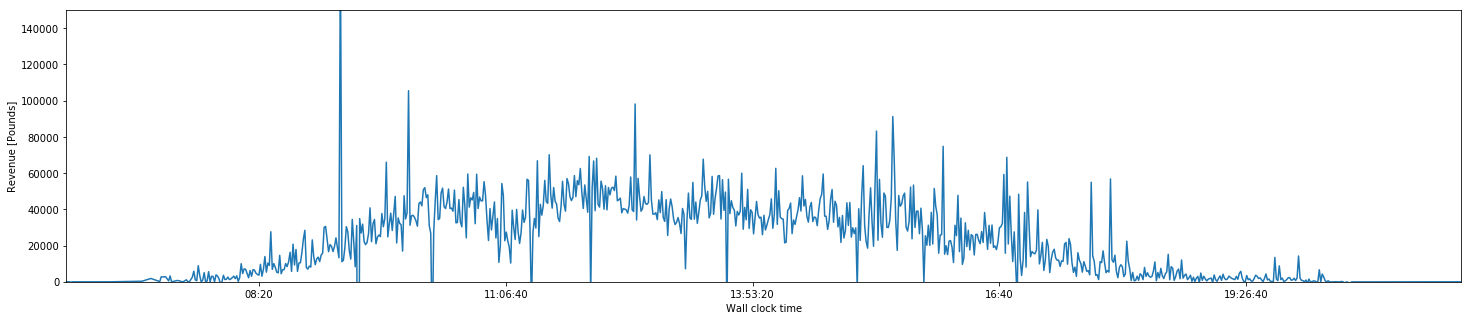

In [53]:
df.groupby('InvoiceTime').Transaction.agg(sum)    \
               .plot(figsize=(25, 5),ylim=(0,150000))  # must be limited to >0
plt.xlabel('Wall clock time')
plt.ylabel('Revenue [Pounds]')
# there are a few time bins with negative spikes: it's the moment when only large cancellations have occurred

In [54]:
# the largest customer by total net revenue (i.e. taking into account also cancellations, in negative)
# is in the UK and has ID 18102.0 and has purchased for 600k pounds
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Total Customer Revenue'],ascending=False).head(10)        

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
18102.0,598215.22,-3580.80,3884.00,1068.0
14646.0,523342.07,-947.08,4992.00,3890.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14911.0,270248.53,-1687.17,1687.17,11613.0
17450.0,233579.39,-3825.36,7144.72,448.0
13694.0,190825.52,-864.00,952.00,1558.0
17511.0,171885.98,-185.30,1401.60,2134.0
12415.0,143269.29,-425.00,1718.40,990.0
16684.0,141502.25,-816.00,1836.00,749.0


In [55]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 13.1k transactions
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,69516.19,-88.50,349.50,13097.0
14911.0,270248.53,-1687.17,1687.17,11613.0
12748.0,49970.13,-1829.84,850.50,7307.0
14606.0,30094.38,-55.10,139.30,6709.0
14096.0,57120.91,-1100.44,1599.26,5128.0
15311.0,113513.07,-275.00,408.00,4717.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14646.0,523342.07,-947.08,4992.00,3890.0
13089.0,113214.19,-1051.20,1051.20,3438.0


In [56]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 12.9 transactions (excluding cancellation transactions)
df.loc[df.Transaction>0]                                                                                      \
    .groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,70884.07,0.19,349.50,12890.0
14911.0,295972.63,1.45,1687.17,11245.0
12748.0,56599.39,0.06,850.50,7228.0
14606.0,30861.06,0.12,139.30,6566.0
14096.0,65164.79,0.42,1599.26,5111.0
15311.0,116771.16,0.21,408.00,4434.0
14156.0,313946.37,1.25,2736.16,4048.0
14646.0,528602.52,0.39,4992.00,3849.0
13089.0,116737.86,1.68,1051.20,3362.0


In [57]:
# the UK generates the largest revenue (16M over the two years),
# surprisingly EIRE is the second largest source of revenue, with 0.6M (despite having only 6 customers, they must be huge customers)
# df.groupby('Country').Transaction.sum().sort_values(ascending=False)
# superseeded by a plot

<a id='the_destination'></a>

[Pippo goes to the cinema](section-title)